In [1]:
import os
import re
import sys
import torch
import scipy.io
import scipy.signal
import mat73
import imageio
import lpips
import random
import torchvision
import random
import time
import skimage._shared.utils
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torch.nn as nn
import torch.fft as fft
import torch.nn.functional as F
import cv2 as cv
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
from torchvision.utils import save_image
from PIL import Image
from skimage import color, data, restoration, img_as_float
from tqdm import tqdm
from unet import UNet
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage.metrics import structural_similarity as ssim
from skimage.restoration import uft
from pypfm import PFMLoader
loader = PFMLoader(color=False, compress=False)
%matplotlib inline

### helper functions

In [5]:
data_dir = '/media/data/salman/Lensless3D/data/'
file_dir = '/media/data/salman/Lensless3D/files/'
dataset_dir = data_dir + 'raw_data/FlyingThings3D_subset/'
data_dict_psf = mat73.loadmat(data_dir+'raw_data/psfs_save_magfs.mat')
psfs = data_dict_psf['psfs'][:,:,:,-25:][::2,::2]

def show_figure(image1, title1, mode="single", image2=None, title2=None, save=False, img_name=None, cmap='gray'):
    
    if mode=='single':
        fig = plt.figure()
        plt.axis('off')
        plt.imshow(image1, cmap=cmap)
        
    if mode=='single-colorbar':
        fig, ax = plt.subplots()
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.2)

        im1 = ax.imshow(image1, cmap=cmap)
        ax.set_title(title1)

        fig.colorbar(im1, cax=cax, orientation='vertical')
        
    elif mode=='comparison':
        fig, (ax1, ax2) = plt.subplots(1, 2)
        divider = make_axes_locatable(ax1)
        cax = divider.append_axes('right', size='5%', pad=0.2)

        im1 = ax1.imshow(image1, cmap=cmap)
        ax1.set_title(title1)

        fig.colorbar(im1, cax=cax, orientation='vertical')
        
        divider = make_axes_locatable(ax2)
        cax = divider.append_axes('right', size='5%', pad=0.2)

        im2 = ax2.imshow(image2, cmap=cmap)
        ax2.set_title(title2)

        fig.colorbar(im2, cax=cax, orientation='vertical')
        fig.tight_layout(pad=1.0)
        fig.show()
        
    if save:
        fig.savefig(img_name)

    
from struct import *
def load_pfm(file_path):
    """
    load image in PFM type.
    Args:
        file_path string: file path(absolute)
    Returns:
        data (numpy.array): data of image in (Height, Width[, 3]) layout
        scale (float): scale of image
    """
    with open(file_path, encoding="ISO-8859-1") as fp:
        color = None
        width = None
        height = None
        scale = None
        endian = None

        # load file header and grab channels, if is 'PF' 3 channels else 1 channel(gray scale)
        header = fp.readline().rstrip()
        if header == 'PF':
            color = True
        elif header == 'Pf':
            color = False
        else:
            raise Exception('Not a PFM file.')

        # grab image dimensions
        dim_match = re.match(r'^(\d+)\s(\d+)\s$', fp.readline())
        if dim_match:
            width, height = map(int, dim_match.groups())
        else:
            raise Exception('Malformed PFM header.')

        # grab image scale
        scale = float(fp.readline().rstrip())
        if scale < 0:  # little-endian
            endian = '<'
            scale = -scale
        else:
            endian = '>'  # big-endian

        # grab image data
        data = np.fromfile(fp, endian + 'f')
        shape = (height, width, 3) if color else (height, width)

        # reshape data to [Height, Width, Channels]
        data = np.reshape(data, shape)
        data = np.flipud(data)

        return data

class VGG(nn.Module):
    """VGG/Perceptual Loss
    
    Parameters
    ----------
    conv_index : str
        Convolutional layer in VGG model to use as perceptual output

    """
    def __init__(self, conv_index: str = '22'):

        super(VGG, self).__init__()
        vgg_features = torchvision.models.vgg19(pretrained=False).features
        modules = [m for m in vgg_features]
        
        if conv_index == '22':
            self.vgg = nn.Sequential(*modules[:8])
        elif conv_index == '54':
            self.vgg = nn.Sequential(*modules[:35])

        vgg_mean = (0.485, 0.456, 0.406)
        vgg_std = (0.229, 0.224, 0.225)
        #self.sub_mean = common.MeanShift(rgb_range, vgg_mean, vgg_std)
        self.vgg.requires_grad = False

    def forward(self, sr: torch.Tensor, hr: torch.Tensor) -> torch.Tensor:
        """Compute VGG/Perceptual loss between Super-Resolved and High-Resolution

        Parameters
        ----------
        sr : torch.Tensor
            Super-Resolved model output tensor
        hr : torch.Tensor
            High-Resolution image tensor

        Returns
        -------
        loss : torch.Tensor
            Perceptual VGG loss between sr and hr

        """

        def _forward(x):
            #x = self.sub_mean(x)
            x = x.cpu()
            x = self.vgg(x)
            return x
            
        vgg_sr = _forward(sr)

        with torch.no_grad():
            vgg_hr = _forward(hr.detach())

        loss = F.mse_loss(vgg_sr, vgg_hr)

        return loss
    
## AIF metrics; gt, recon must be scaled from 0-1, dim:(128, 128, 3)

loss_fn_alex = lpips.LPIPS(net='alex')

def PSNR(gt, recon):
    mse = np.mean((gt - recon) ** 2)
    if(mse == 0): 
        return 100
    max_pixel = 1.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

def SSIM(gt, recon):
    return ssim(gt, recon, multichannel=True)

def LPIPSval(gt, recon):
    gt = torch.from_numpy(gt.transpose(2, 0, 1).reshape(1, 3, 128, 128)).type(torch.float32)
    recon = torch.from_numpy(recon.transpose(2, 0, 1).reshape(1, 3, 128, 128)).type(torch.float32)
    return loss_fn_alex(gt, recon).item()
    
## Depth metrics

def RMSE(gt, recon):
    mse = np.mean((gt - recon) ** 2)
    return np.sqrt(mse)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/lensless/.conda/envs/myenv/lib/python3.7/site-packages/lpips/weights/v0.1/alex.pth


### dataloader

In [6]:
class TrainDataset(Dataset):
    def __init__(self, meas_folder):
        self.meas_folder = meas_folder
    
    def __len__(self):
        return 21818

    def __getitem__(self, index):

        depth = np.zeros([1, 128, 128])
        ct_depth = np.zeros([1, 128, 128])
        allfocus = np.zeros([1, 3, 128, 128])
        
        img_no = '0'*(7-len(str(index))) + str(index)
        meas = np.array(Image.open(data_dir+'train_set/'+self.meas_folder+'/im'+str(img_no)+'.png'))
        disp = load_pfm(dataset_dir+'train/disparity/left/'+str(img_no)+'.pfm')[::2, ::2][:256, 100:356]
        depth_ = 1/(np.abs(disp))
        depth_ = 3.6 + (20-3.6)*(depth_-depth_.min())/(depth_.max()-depth_.min())
        ct_depth[0, :, :] = depth_[::2,::2]
        depth[0,...] = np.load(data_dir+'train_set/quan_depth/im'+str(img_no)+'.npy')
        allfocus[0,...] = np.array(Image.open(dataset_dir+'train/left/'+str(img_no)+'.png'))[::2, ::2, :][:256, 100:356, :][::2,::2,:].transpose(2, 0, 1)/255
        
        return meas, depth, allfocus, ct_depth

class ValDataset(Dataset):
    def __init__(self, meas_folder):
        self.meas_folder = meas_folder
    
    def __len__(self):
        return 3000

    def __getitem__(self, index):

        depth = np.zeros([1, 128, 128])
        ct_depth = np.zeros([1, 128, 128])
        allfocus = np.zeros([1, 3, 128, 128])
        
        img_no = '0'*(7-len(str(index))) + str(index)
        meas = np.array(Image.open(data_dir+'val_set/'+self.meas_folder+'/im'+str(img_no)+'.png'))
        disp = load_pfm(dataset_dir+'val/disparity/left/'+str(img_no)+'.pfm')[::2, ::2][:256, 100:356]
        depth_ = 1/(np.abs(disp))
        depth_ = 3.6 + (20-3.6)*(depth_-depth_.min())/(depth_.max()-depth_.min())
        ct_depth[0, :, :] = depth_[::2,::2]
        depth[0,...] = np.load(data_dir+'val_set/quan_depth/im'+str(img_no)+'.npy')
        allfocus[0,...] = np.array(Image.open(dataset_dir+'val/left/'+str(img_no)+'.png'))[::2, ::2, :][:256, 100:356, :][::2,::2,:].transpose(2, 0, 1)/255
        
        return meas, depth, allfocus, ct_depth

class TestDataset(Dataset):
    def __init__(self, meas_folder):
        self.meas_folder = meas_folder
    
    def __len__(self):
        return 1248

    def __getitem__(self, index):

        depth = np.zeros([1, 128, 128])
        ct_depth = np.zeros([1, 128, 128])
        allfocus = np.zeros([1, 3, 128, 128])
        
        img_no = '0'*(7-len(str(index+3000))) + str(index+3000)
        meas = np.array(Image.open(data_dir+'test_set/'+self.meas_folder+'/im'+str(img_no)+'.png'))
        disp = load_pfm(dataset_dir+'val/disparity/left/'+str(img_no)+'.pfm')[::2, ::2][:256, 100:356]
        depth_ = 1/(np.abs(disp))
        depth_ = 3.6 + (20-3.6)*(depth_-depth_.min())/(depth_.max()-depth_.min())
        ct_depth[0, :, :] = depth_[::2,::2]
        depth[0,...] = np.load(data_dir+'test_set/quan_depth/im'+str(img_no)+'.npy')
        allfocus[0,...] = np.array(Image.open(dataset_dir+'val/left/'+str(img_no)+'.png'))[::2, ::2, :][:256, 100:356, :][::2,::2,:].transpose(2, 0, 1)/255
        
        return meas, depth, allfocus, ct_depth

### training

In [ ]:
drng = torch.from_numpy(data_dict_psf['drng'][-25:])
device = 'cuda:0'
model = UNet(in_channels=25,
             out_channels=26,
             in_layer='filter',
             device = device,
             batch_size = 7,
             n_blocks=2,
             start_filts = 64,
             attention = True,
             activation=nn.ELU(),
             normalization='batch',
             conv_mode='same',
             out_layer='3Dvol',
             dim=3).to(device)

PATH = file_dir+"models/final_AAAI_model.pt"
state_dict = torch.load(PATH,map_location='cpu')
model.load_state_dict(state_dict)
model.to(device)

batch_size = 7
train_dataset = TrainDataset(meas_folder='meas_rand_noise')
train_dl = DataLoader(train_dataset, batch_size, shuffle=True)
criterion1 = VGG()
criterion2 = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
n_epochs = 50

for epoch in range(n_epochs):
    epoch_loss = 0
    print('epoch:'+str(epoch+1)+'/'+str(n_epochs))
    model.train()
    for i, (meas, depth, allfocus, ct_depth) in tqdm(enumerate(train_dl)):
        optimizer.zero_grad()
        yhat = model(meas.to(device).permute(0, 3, 1, 2).type(torch.float32))
        loss = 1000*criterion1(yhat[:, 0,...].squeeze(1), allfocus.squeeze(1).to(device).type(torch.float32)) + criterion2(yhat[:, 1:26, 0, ...].squeeze(2), depth.to(device).squeeze(1).long())
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    print('loss:'+ str(epoch_loss/(i+1)))
    
    k = 100
    x = torch.from_numpy(train_dataset[k][0]).unsqueeze(0).permute(0, 3, 1, 2).to(device).type(torch.float32)
    model.eval()
    with torch.no_grad():
        out_d = data_dict_psf['drng'][-25:][torch.argmax(model(x)[0, 1:26,0,...], dim=0).cpu()]
        out_aif = model(x)[0, 0,...].cpu().numpy()
        out_aif -= np.min(out_aif)
        out_aif /= np.max(out_aif)
        
    show_figure(out_d, "depth-recon", "comparison", data_dict_psf['drng'][-25:][train_dataset[k][1][0].astype(np.int64)], "depth-gt")
    show_figure(out_aif.transpose(1, 2, 0), "aif-recon", "comparison", train_dataset[k][2][0].transpose(1, 2, 0), "aif-gt")

    PATH = data_dir+"models/model_rgbdnet_"+str(epoch+1)+".pt"
    torch.save(model.state_dict(), PATH)

### train set results

In [ ]:
device = 'cuda:0'
model = UNet(in_channels=25,
             out_channels=26,
             in_layer='filter',
             device = device,
             batch_size = 7,
             n_blocks=2,
             start_filts = 64,
             attention = True,
             activation=nn.ELU(),
             normalization='batch',
             conv_mode='same',
             out_layer='3Dvol',
             fixed=False,
             dim=3).to(device)
state_dict = torch.load(PATH,map_location='cpu')
model.load_state_dict(state_dict)
model.to(device)

for i in range(10):
    k = np.random.randint(21818)
    x = torch.from_numpy(train_dataset[k][0]).unsqueeze(0).permute(0, 3, 1, 2).to(device).type(torch.float32)
    model.eval()    
    with torch.no_grad():
        out_d = data_dict_psf['drng'][-25:][torch.argmax(model(x)[0, 1:26,0,...], dim=0).cpu()]
        out_aif = model(x)[0, 0,...].cpu().numpy()
        out_aif -= np.min(out_aif)
        out_aif /= np.max(out_aif)

    show_figure(out_d, "depth-recon", "comparison", data_dict_psf['drng'][-25:][train_dataset[k][1][0].astype(np.int64)], "depth-gt")
    show_figure(out_aif.transpose(1, 2, 0), "aif-recon", "comparison", train_dataset[k][2][0].transpose(1, 2, 0), "aif-gt")

### val set results

In [ ]:
val_dataset = ValDataset(meas_folder='meas_rand_noise')

for i in range(10):
    k = np.random.randint(3000)
    x = torch.from_numpy(val_dataset[k][0]).unsqueeze(0).permute(0, 3, 1, 2).to(device).type(torch.float32)
    model.eval()
    with torch.no_grad():
        out_d = data_dict_psf['drng'][-25:][torch.argmax(model(x)[0, 1:26,0,...], dim=0).cpu()]
        out_aif = model(x)[0, 0,...].cpu().numpy()
        out_aif -= np.min(out_aif)
        out_aif /= np.max(out_aif)
        
    show_figure(out_d, "depth-recon", "comparison", data_dict_psf['drng'][-25:][val_dataset[k][1][0].astype(np.int64)], "depth-gt")
    show_figure(out_aif.transpose(1, 2, 0), "aif-recon", "comparison", val_dataset[k][2][0].transpose(1, 2, 0), "aif-gt")

### test set results

100%|██████████| 4/4 [00:03<00:00,  1.22it/s]


0.8202373313515099 22.08744476379747 4.524446300220775 5.333661525194548 0.0800339812412858


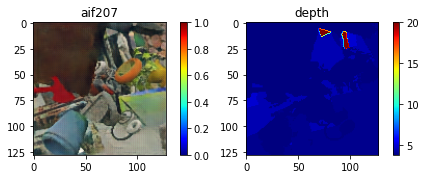

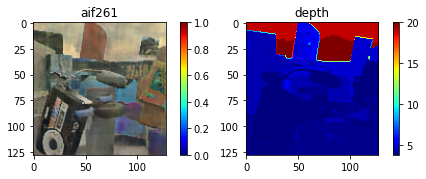

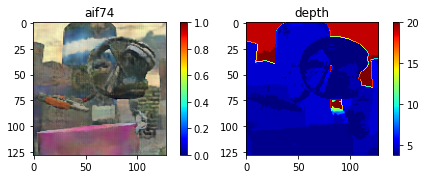

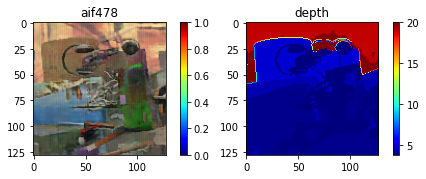

In [16]:
device = 'cuda:2'
model = UNet(in_channels=25,
             out_channels=26,
             in_layer='filter',
             device = device,
             batch_size = 7,
             n_blocks=2,
             start_filts = 64,
             attention = True,
             activation=nn.ELU(),
             normalization='batch',
             conv_mode='same',
             out_layer='3Dvol',
             dim=3).to(device)
PATH = file_dir+"models/final_AAAI_model.pt"
state_dict = torch.load(PATH,map_location='cpu')
model.load_state_dict(state_dict)
model.to(device)
model.eval()
test_indices = np.load('test_indices.npy')

test_indices = [207, 261, 74, 478]
for num in range(50, 60, 10):    
    
    test_dataset = TestDataset(meas_folder='meas_'+str(num))
    rmse_sum = 0
    psnr_sum = 0
    crmse_sum = 0
    lpipsval_sum = 0
    ssim_sum = 0

    for index in tqdm(range(len(test_indices))):
        k = test_indices[index]
        x = torch.from_numpy(test_dataset[k][0]).unsqueeze(0).permute(0, 3, 1, 2).to(device).type(torch.float32)
        with torch.no_grad():
            out_d = data_dict_psf['drng'][-25:][torch.argmax(model(x)[0, 1:26,...], dim=0)[0].cpu()]
            out_aif = model(x)[0, 0,...].cpu().numpy()
            out_aif -= np.min(out_aif)
            out_aif /= np.max(out_aif)
        ssim_sum += SSIM(test_dataset[k][2][0].transpose(1, 2, 0), out_aif.transpose(1, 2, 0))
        psnr_sum += PSNR(test_dataset[k][2][0].transpose(1, 2, 0), out_aif.transpose(1, 2, 0))
        rmse_sum += 10*RMSE(data_dict_psf['drng'][-25:][test_dataset[k][1][0].astype(np.int64)], out_d)
        crmse_sum += 10*RMSE(test_dataset[k][3][0], out_d)
        lpipsval_sum += LPIPSval(test_dataset[k][2][0].transpose(1, 2, 0), out_aif.transpose(1, 2, 0))
        show_figure(out_aif.transpose(1, 2, 0), 'aif'+str(k), 'comparison', out_d, 'depth', cmap='jet')
    print(ssim_sum/len(test_indices), psnr_sum/len(test_indices), rmse_sum/len(test_indices), crmse_sum/len(test_indices), lpipsval_sum/len(test_indices))


### real results

/home/lensless/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


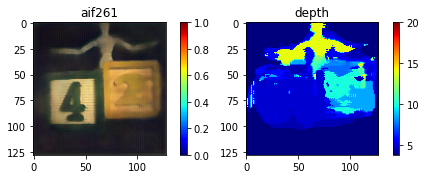

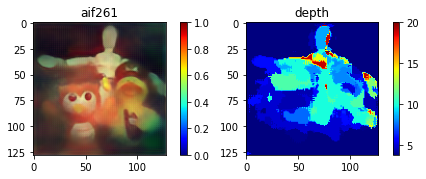

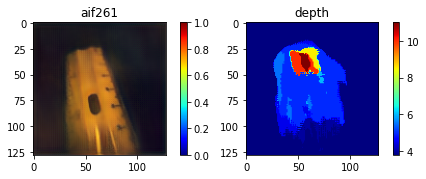

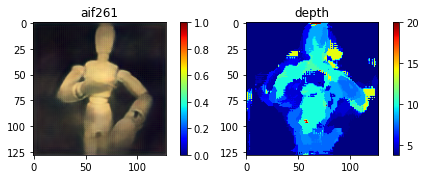

In [11]:
PATH = file_dir+"models/final_AAAI_model.pt"
device = 'cuda:2'
model = UNet(in_channels=25,
         out_channels=26,
         in_layer='filter',
         device = device,
         batch_size = 7,
         n_blocks=2,
         start_filts = 64,
         attention = True,
         activation=nn.ELU(),
         normalization='batch',
         conv_mode='same',
         out_layer='3Dvol',
         dim=3).to(device)
state_dict = torch.load(PATH,map_location='cpu')
model.load_state_dict(state_dict)
model.to(device)

real_data = ['avgCap20.mat', 'avgCap10_1.mat','avgCap30_1.mat',  'avgCap4_zebra.mat', 'avgCap4_1.mat', 'avgCap4_owl.mat', 'avgCap1.mat', 'avgCap10_2.mat', 'avgCap10_3.mat', 'avgCap50.mat', 'avgCap30.mat', 'avgCap4.mat', 'avgCap10.mat']
for i in range(4):
    if i==0:
        data_dict = scipy.io.loadmat(data_dir+'raw_data/avgCap10.mat')

    else:
        data_dict = mat73.loadmat(data_dir+'raw_data/'+real_data[i-1])

    img = data_dict['avgCap']
    left = (img.shape[0]//2-128)//2
    top = (img.shape[1]//2-128)//2
    measurement = np.zeros([456, 684, 3])
    measurement[:, :, 0] = img[::2, ::2, 0]
    measurement[:, :, 1] = img[::2, ::2, 1]
    measurement[:, :, 2] = img[::2, ::2, -1]
    measurement /=np.max(measurement)
    x = torch.from_numpy((255*measurement)).unsqueeze(0).permute(0, 3, 1, 2).to(device).type(torch.float32)
    model.eval()

    with torch.no_grad():
        out_d = data_dict_psf['drng'][-25:][torch.argmax(model(x)[0, 1:26,0,...], dim=0).cpu()]
        out_aif = model(x)[0, 0,...].cpu().numpy()
        out_aif -= np.min(out_aif)
        out_aif /= np.max(out_aif)
    show_figure(out_aif.transpose(1, 2, 0), 'aif'+str(k), 'comparison', out_d, 'depth', cmap='jet')